In [1]:
import time
import ROOT
import numpy as np
import pandas as pd
import root_pandas as rpd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from root_pandas import read_root
%run functions.ipynb
%run constants.ipynb

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.
Welcome to JupyROOT 6.14/06


In [2]:
def getDataPart(inputFiles):
    
    cols = []
    scalar = []
    scalar.append('evid')
    scalar.append('xsec')
    scalar.append('ntrials')    
    scalar.append('x')
    scalar.append('y')
    scalar.append('Q2')
    scalar.append('W2')
    scalar.append('pt_electron')
    scalar.append('phi_photon')
    
    cols.append('p_part')
    cols.append('eta_part')
    cols.append('theta_part')
    cols.append('phi_part')
    
    scalar.append('p_electron')
    scalar.append('eta_electron')
    scalar.append('theta_electron')
    
    lists = scalar + cols
    dataframes = []
    for inputFilename in inputFiles:
        start = time.time()
        df = read_root(inputFilename, columns=lists,flatten=cols)
        dataframes.append(df)
        end = time.time()
        print '\n', 'Processed', inputFilename, 'in',  '%2.1f'%(end-start), 'seconds'
    return pd.concat([x for x in dataframes])

In [3]:
radii_large = [0, 10, 20, 30, 40]
r_labels_large = ['0','10','20','30','40']
angles = [90, 139.604937421, 164.585373193, 174.299529125, 177.90141703, 180, 182.09858297, 185.700470875, 195.414626807,
          220.395062579, 270, 319.604937421, 344.585373193, 354.299529125, 357.90141703, 360]
eta_labels = ['0','-1','-2','-3','-4','$-\infty$','-4','-3','-2','-1','0','1','2','3','4', '$\infty$']
nr_large = 40
ntheta = 90

In [4]:
files_part = ["$HOME/EIC/output/1110.root"]
b = getDataPart(files_part)


Processed $HOME/EIC/output/1110.root in 1941.2 seconds


In [5]:
# general cuts
df4 = applyCut(b, 'y > 0.1 and y < 0.85', '0.1 < y < 0.85')
df4 = applyCut(df4, 'pt_electron > 5', 'pt_electron > 5')
df4 = applyCut(df4, 'Q2 > 50', 'Q2 > 50')
df4 = applyCut(df4, 'W2 > 4', 'W2 > 4')
df4.eval('theta_part_neg = 6.28318530718 - theta_part', inplace = True)

0.1 < y < 0.85 10912462  fraction kept: 21.7
pt_electron > 5 834524  fraction kept: 7.6
Q2 > 50 506943  fraction kept: 60.7
W2 > 4 506943  fraction kept: 100.0


In [6]:
def fixPhi(df, particle):
    string = 'phi_part'
    a = (df.loc[df['phi_' + particle] < 0]).index # a list of row indices (jet id) with negative phi_photon values
    for i in range(0,len(a)):
        df.at[a[i],'phi_' + particle] = df.at[a[i],'phi_' + particle] + 6.28318530718
    print 'Fixed ' + particle + ' phi range'
    df_new = df.eval('delta_phi_' + particle + ' = phi_' + particle + ' - ' + string)
    b = (df_new.loc[df_new['delta_phi_' + particle] > np.pi]).index
    for i in range(0,len(b)):
        df_new.at[b[i],'delta_phi_' + particle] = -6.28318530718 + df_new.at[b[i],'delta_phi_' + particle]
    c = (df_new.loc[df_new['delta_phi_' + particle] < (-1) * np.pi]).index
    for i in range(0,len(c)):
        df_new.at[c[i],'delta_phi_' + particle] = 6.28318530718 + df_new.at[c[i],'delta_phi_' + particle]
    df_new_new = df_new.eval('delta_phi_' + particle + '_abs = abs(delta_phi_' + particle + ')')    
    print 'Fixed ' + particle + ' delta phi range'
    return df_new_new

In [8]:
d = fixPhi(df4, 'photon')
d = applyCut(d, 'delta_phi_photon_abs < 0.4', 'delta_phi_photon_abs < 0.4')

Fixed photon phi range
Fixed photon delta phi range
delta_phi_photon_abs < 0.4 267286  fraction kept: 52.7


In [9]:
df_e = keepOneJet(df4)
d_e = keepOneJet(d)


Remove extra jets 52965  fraction kept: 10.4

Remove extra jets 52902  fraction kept: 19.8


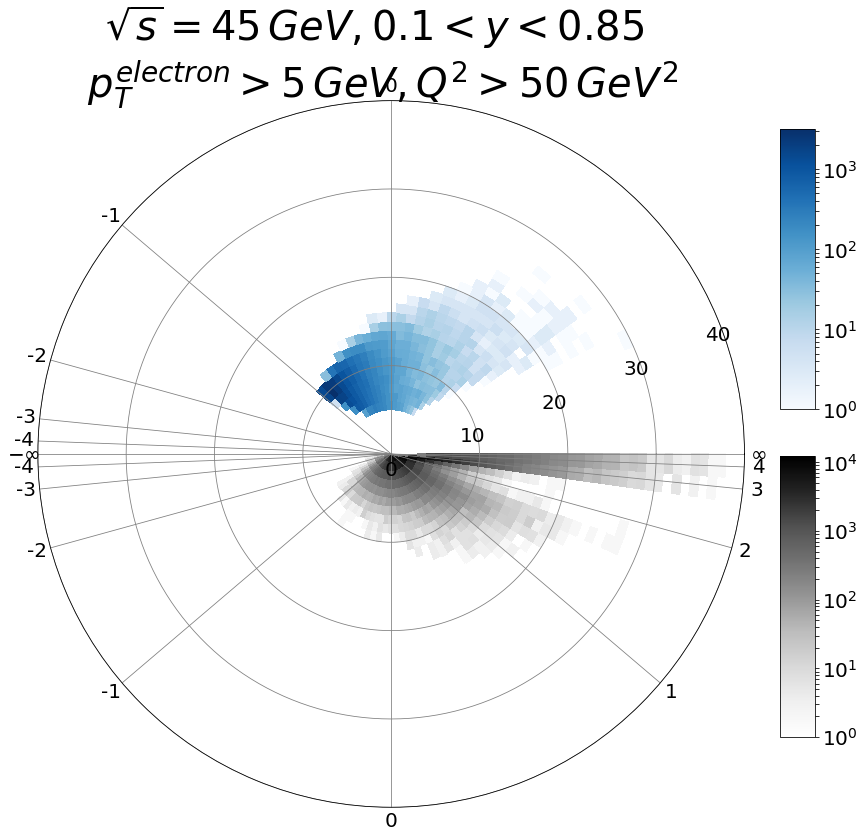

In [10]:
fig = plt.figure(figsize=(16,13))
plt.subplots_adjust(wspace=0, hspace=0)
    
plt.subplot(111, polar=True)
radii = radii_large
r_labels = r_labels_large
nr = nr_large
r_edges = np.linspace(0, nr, nr + 1)
theta_edges = np.linspace(0, 2*np.pi, ntheta + 1)
H_e = plt.hist2d(df_e['p_electron'], df_e['theta_electron'], [r_edges, theta_edges])[0]
H_q = plt.hist2d(df4['p_part'], df4['theta_part_neg'], [r_edges, theta_edges])[0]
plt.cla()
    
Theta, R = np.meshgrid(theta_edges, r_edges)
im_e = plt.pcolormesh(Theta, R, H_e, cmap='Blues', norm=LogNorm())
im_q = plt.pcolormesh(Theta, R, H_q, cmap='Greys', norm=LogNorm())
plt.rgrids(radii, labels=r_labels, fontsize=20)
plt.thetagrids(angles, labels=eta_labels, fontsize=20)
plt.grid(color='grey')
cbar_e = plt.colorbar(im_e, shrink=0.7, pad=0.01, cax=plt.axes([0.85, 0.55, 0.03, 0.3]))
cbar_e.ax.tick_params(labelsize=20)
cbar_q = plt.colorbar(im_q, shrink=0.7, pad=0.01, cax=plt.axes([0.85, 0.2, 0.03, 0.3]))
cbar_q.ax.tick_params(labelsize=20)
plt.suptitle('$\sqrt{s} = 45 \, GeV, 0.1 < y < 0.85$ \n $p_T^{electron} > 5 \, GeV, Q^2 > 50 \, GeV^2$', fontsize=40)
   
plt.savefig('images/hadron_50_5.pdf', bbox_inches='tight')

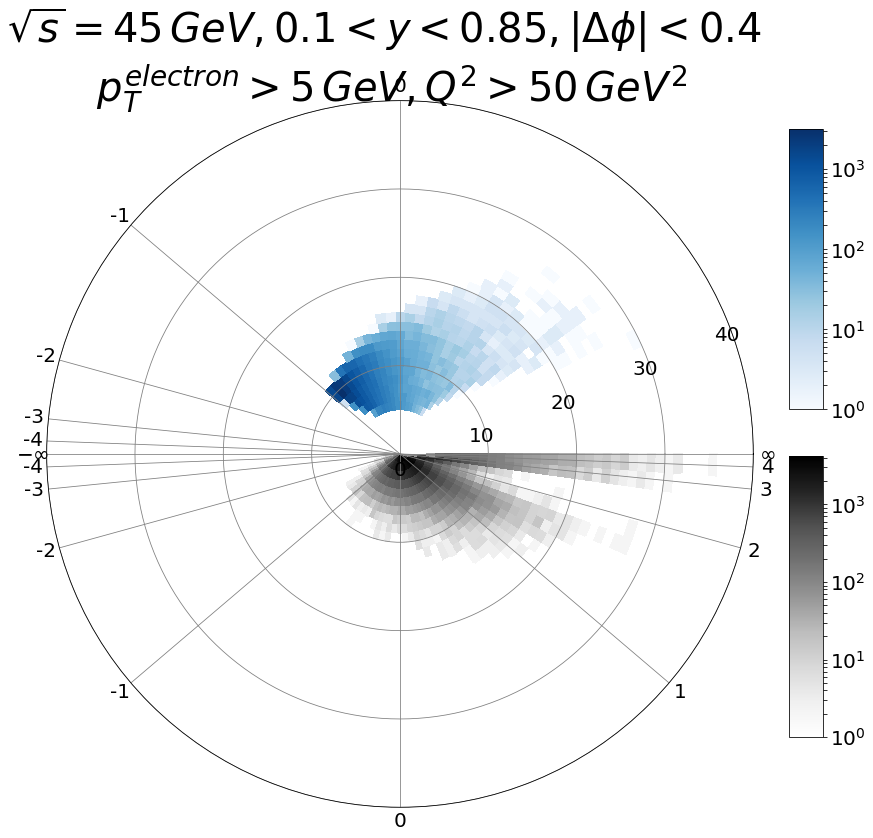

In [11]:
fig = plt.figure(figsize=(16,13))
plt.subplots_adjust(wspace=0, hspace=0)
    
plt.subplot(111, polar=True)
radii = radii_large
r_labels = r_labels_large
nr = nr_large
r_edges = np.linspace(0, nr, nr + 1)
theta_edges = np.linspace(0, 2*np.pi, ntheta + 1)
H_e = plt.hist2d(d_e['p_electron'], d_e['theta_electron'], [r_edges, theta_edges])[0]
H_q = plt.hist2d(d['p_part'], d['theta_part_neg'], [r_edges, theta_edges])[0]
plt.cla()
    
Theta, R = np.meshgrid(theta_edges, r_edges)
im_e = plt.pcolormesh(Theta, R, H_e, cmap='Blues', norm=LogNorm())
im_q = plt.pcolormesh(Theta, R, H_q, cmap='Greys', norm=LogNorm())
plt.rgrids(radii, labels=r_labels, fontsize=20)
plt.thetagrids(angles, labels=eta_labels, fontsize=20)
plt.grid(color='grey')
cbar_e = plt.colorbar(im_e, shrink=0.7, pad=0.01, cax=plt.axes([0.85, 0.55, 0.03, 0.3]))
cbar_e.ax.tick_params(labelsize=20)
cbar_q = plt.colorbar(im_q, shrink=0.7, pad=0.01, cax=plt.axes([0.85, 0.2, 0.03, 0.3]))
cbar_q.ax.tick_params(labelsize=20)
plt.suptitle('$\sqrt{s} = 45 \, GeV, 0.1 < y < 0.85, |\Delta \phi| < 0.4$ \n $p_T^{electron} > 5 \, GeV, Q^2 > 50 \, GeV^2$', fontsize=40)
   
plt.savefig('images/hadron_50_5_dphi.pdf', bbox_inches='tight')